### Import packages and establish notebook settings

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.html.use_mathjax', False) # normalize fonts for pandas display
pd.options.display.max_colwidth = None

# custom functions
from utils import *
from jupyterthemes import jtplot
jtplot.style()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylerpoore/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### My Fathers Jokes

In [2]:
# Take a look at my fathers jokes
for joke in DADS_JOKES:
    print('--------')
    print(f'{joke[0]}\n{joke[1]}')

--------
Police car loses wheels to thief!
Cops are working tirelessly to nab suspect
--------
My friend David had his id stolen
now he is just Dav.
--------
I tried out a few jokes about unemployed people
but none of them ever worked
--------
I had a patient that talked and talked and talked...
...And, tt was clear that there needed to be an organization similar to Q-Anon for compulive talkers called Onandon-andon
--------
My ex-wife still misses me.
But her aim is starting to improve.
--------
An invisible man married an invisible woman.
The kids were nothing to look at either.
--------
Did you know that a raven has 17 rigid feathers called pinyans, while a crow only has 16?
Apparently, the only difference between a raven and a crow is a matter of a pinyan.
--------
A painter was the only painter in town...
...And he tended to take advantage of this by diluting his paint a bit with turpentine. One day he was asked to paint the church steeple. He was about half done, standing high on 

### Read-in and explore the dataset
The dataset is downloaded and read into a pandas data frame. A quick examination of the data shows that the dataset contains one million instances with 12 features, most of which aren't relevent to

In [3]:
# extract the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')

In [4]:
# examine the data
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i/i_am_soooo_glad_im_not_circumcised/,self.jokes,NaN,My corona is covered with foreskin so it is not exposed to viruses.,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for recording your bowel movements?,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj/what_is_the_difference_between_my_wife_and_my/,self.jokes,NaN,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",What is the difference between my wife and my vacuum?,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh/my_last_joke_for_now/,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg/the_nintendo_64_turns_18_this_week/,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [5]:
df.shape

(1000000, 12)

In [6]:
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [7]:
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


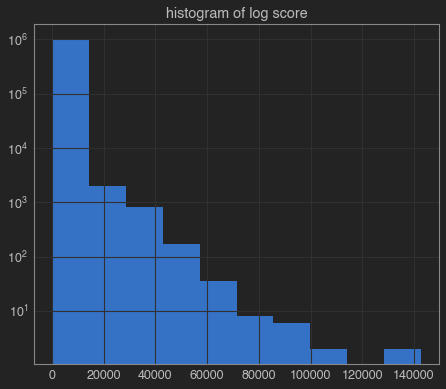

In [8]:
plt.hist(df['score'], log=True)
plt.title('histogram of log score')
save_fig('scores distribution')

In [9]:
# define some parameters 
CLASS_SIZE = 100000
TRAIN_SIZE = 0.95
MIN_UPVOTES = df['score'].min()
MAX_UPVOTES = df['score'].max()
TITLE_MAX_LEN = 100
SELFTEXT_MAX_LEN = 500

## Data Cleaning

Our raw data is truly unruly, being sourced from the [r/Jokes subreddit](https://www.reddit.com/r/Jokes/), and so will require a fair bit of wrangling to get into a useable form. Part of the challenge is that the relevent information we are looking to isolate (the joke and punchline) are within a sea of noisy data; raw internet data tends to be replete with odd characters, emojis, hmtl character references, links, mispellings, null values, and user edits that will add to the noisiness, making the data more unruly and harder to work with. I will thus be proceeding carefully by closely examing the data during cleaning and making judicious use of test cases to ensure that I am getting the results I expect.

In [10]:
# boolean masks
# where selftext isnull (no punchline)
is_null = df['selftext'].isnull()

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.lower().str.contains(r"[^a-z\s]removed[^a-z\s]", regex=True)) | (df['title'].str.lower().str.contains(r"[^a-z\s]removed[^a-z\s]", regex=True)) 

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.lower().str.contains(r"[^a-z\s]deleted[^a-z\s]", regex=True)) | (df['title'].str.lower().str.contains(r"[^a-z\s]deleted[^a-z\s]", regex=True)) 

# reposts
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

In [11]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565332, 12)

In [12]:
# what are nans?
df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10) 

,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [13]:
df_cleaned = df_cleaned[~is_null]

In [14]:
# find edits:
PATTERN = "(?i)[^a-z](edit)\W.+"

# clean posts to change this ... 
edits_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[edits_idx][['title', 'selftext']].head()

,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit.\n\nShe didn't even know that rain was something you need to come in to from out of.\n\n&amp;#x200B;\n\nEDIT: IOW she didn't like sentences that ended in five prepositions.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?""\n\n\n\n\n\n\nThe other parrot replied ""Oh my, a talking bird.""\n\n\n\n\n*edit: spelling*"
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. \n\nI say pizz and past, like a _real_ American.\n\n\n\nEdit: wording"
1096,A man with a COVID-19 walks into the bar,...and is told to leave. \n\n[edit]: I'm gonna go offline for 14 days for hating myself.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads.\n\nOwned.\n\nEdit: punch line


In [15]:
# remove user edits added after user posted content, remove newline characters
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x:re.sub(PATTERN, " ", x.replace("\n", " ")))

# into this ...
df_cleaned[['title', 'selftext']].loc[edits_idx].head()

,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of. &amp;#x200B;
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."""
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American."
1096,A man with a COVID-19 walks into the bar,...and is told to leave.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned.


In [16]:
# removing html character references and user comments (put in by [...] or (...))
PATTERN = r"(&\S+;)|(\(.*?\))|(\[.*?\])"

# get examples of instances containing pattern
html_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[html_idx][['title', 'selftext']].head()

,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. &amp;#x200B; ""Many moons pass, and chief Walking Horse no go number two."" He complains. &amp;#x200B; The doctor reaches into his cabinet and fishes out a mild laxative. &amp;#x200B; ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" &amp;#x200B; The chief took the little bottle, and left back to his village. &amp;#x200B; Two days later, ask the Doctor requested, he's back. &amp;#x200B; ""Chief Walking Horse, have you moved yet?"" &amp;#x200B; The chief slowly shakes his head no. &amp;#x200B; ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" &amp;#x200B; The chief nods his head yes, and leaves to return to his village. &amp;#x200B; This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. &amp;#x200B; A few days later, while visiting a close by settlement, the Doctor sees the Chief. &amp;#x200B; ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" &amp;#x200B; The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage: (Read from bottom to top)
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches (so he gets $7.5M). Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: [tearing up] ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: [angry] ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""


In [17]:
# see changes

df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, " ", x))
df_cleaned.loc[html_idx][['title', 'selftext']].head()

,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. ""Many moons pass, and chief Walking Horse no go number two."" He complains. The doctor reaches into his cabinet and fishes out a mild laxative. ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" The chief took the little bottle, and left back to his village. Two days later, ask the Doctor requested, he's back. ""Chief Walking Horse, have you moved yet?"" The chief slowly shakes his head no. ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" The chief nods his head yes, and leaves to return to his village. This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. A few days later, while visiting a close by settlement, the Doctor sees the Chief. ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage:
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches . Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""


In [18]:
# emojis
PATTERN = r"[\U00002122-\U0010ffff]|[\u00A9-\u00AE]"

# generate instances of patterns for showing
emoji_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
df_cleaned.loc[emoji_idx][['title', 'selftext']].head()

,title,selftext
1175,British people are like: “I’m Bri ish”,...and here’s the t☕️
1265,This social distancing is going too far.,I just went to make a cake and the first line on the packet said separate 2 eggs 🥚 🥚
2412,"A woman walks into a doctor's office and takes off her shirt and bra, revealing an H-shaped rash. ""Can you fix this rash?"" asked the woman.","""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Harvard graduate, he insists on wearing his Harvard shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an Y-shaped rash. ""Can you fix this rash?"" asked the woman. ""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Yale graduate, he insists on wearing his Yale shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an W-shaped rash. ""Can you fix this rash?"" asked the woman. ""Let me guess,"" said the doctor, ""your dating a Washington graduate?"" ""No, she's a Michigan graduate.""﻿"
4129,"So I said to my girl, it’s not that I’m always horny",It’s just that you’re always beautiful!🇨🇦
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away 😂😂😂 L😎L


*note that the selftext at id location 2412 does not show any emoji as identified by the pattern, but copying and pasting into a text editor shows a hidden emoji unicode character tailing the string:*

![example of hidden char](./images/jokes/hidden_utf_char.png)

In [19]:
# examine changes
df_cleaned[['title', 'selftext']] = df_cleaned[['title','selftext']].applymap(lambda x: re.sub(PATTERN, "", x))
df_cleaned[['title', 'selftext']].loc[emoji_idx].head()

,title,selftext
1175,British people are like: “I’m Bri ish”,...and here’s the t
1265,This social distancing is going too far.,I just went to make a cake and the first line on the packet said separate 2 eggs
2412,"A woman walks into a doctor's office and takes off her shirt and bra, revealing an H-shaped rash. ""Can you fix this rash?"" asked the woman.","""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Harvard graduate, he insists on wearing his Harvard shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an Y-shaped rash. ""Can you fix this rash?"" asked the woman. ""Where did you get this rash?"" asked the doctor. ""My boyfriend is such a proud Yale graduate, he insists on wearing his Yale shirt when we have sex."" The doctor gives the woman a prescription for her rash, and the woman leaves. Then another woman walks into the office and takes off her shirt and bra, revealing an W-shaped rash. ""Can you fix this rash?"" asked the woman. ""Let me guess,"" said the doctor, ""your dating a Washington graduate?"" ""No, she's a Michigan graduate."""
4129,"So I said to my girl, it’s not that I’m always horny",It’s just that you’re always beautiful!
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away LL


In [20]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['selftext'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 1) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 1) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

327016 samples match


### Filtering for my dad

In [21]:
# meta jokes
# boolean mask that identifies strings with reddit posts
PATTERN = r"(\s\/?[ur]\/\D)|(\sclick\s)|(sub)?(reddit)|\S(vote)s?|(\sop\s)|https?\S+|([a-z]?(re)?post(?=(ed)|[^a-z]|$))|_"
is_meta = df_cleaned['title'].str.lower().str.contains(PATTERN, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN, regex=True)
df_cleaned[is_meta].sample(10)[['title', 'selftext', 'score']]

,title,selftext,score
890190,"When Bernie Sanders was in highschool, why did he have more friends than normal, fail English class, and never study?",He was a bit more social than normal. He refused to use capitalism. He was always on Reddit.,0
964635,I just join reddit and suddenly discover that my name is on the front page!,Final Final,952
427668,Pros and cons of post-crucifixion,Cons: No longer able to eat Skittles Pros: Makes hide-and-seek super easy,2
983780,How man redditors does it take to change a lightbulb?,Ten. One to change it and nine to downvote for no reason.,0
977292,A feminist and a reddit admin walk into a bar...,"Just kidding, they couldn't fit through the door.",7
39112,"The other day, I saw a highly upvoted pic of a lamp post","The next day, near the top of the SAME subreddit, I saw a highly upvoted pic of a lamp repost.",5
439472,What does a coconut become on Reddit?,A jackfruit.,5
825072,I never understood the appeal of /r/titler...,"But you know, different strokes for fascist folks",1
650840,How are posts on /r/jokes like Jesus?,You can kill one but it comes back in three days,289
544990,A single sperm has 37.5 MB of DNA information in it. That means an average ejaculation represents a data transfer of 1587.5 TB,That's a lot of information to swallow -wow thanks for the upvotes and gold,53949


In [22]:
df_cleaned = df_cleaned[~is_meta]

In [23]:
# offensive jokes
# boolean mask that identifies strings with offensive content
is_offensive = df_cleaned['title'].str.lower().str.contains(PATTERN_NSFW, regex=True) | df_cleaned['selftext'].str.lower().str.contains(PATTERN_NSFW, regex=True)

# # uncomment below to check this NSFW
# df_cleaned[is_offensive & is_short].sample(30)[['title', 'selftext', 'score']]

In [24]:
df_cleaned = df_cleaned[~is_offensive]

In [25]:
# Filter entries that are short, but meet other necessary criteria again
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 2) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print(f"{len(df_cleaned[~neg_class])} samples match")

298525 samples match


In [26]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

maximum sampling size is 78936
 proceeding with this value...
***** calculating *****
78936
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 100000
current size 76668


### Make the positive and negative class labels and concatenate the dataframe

          count        mean          std   min   25%   50%    75%       max
target                                                                     
False   76668.0    0.000000     0.000000   0.0   0.0   0.0    0.0       0.0
True    76668.0  690.893189  3503.872494  18.0  28.0  54.0  161.0  136359.0
Saving figure class distribution after cleaning


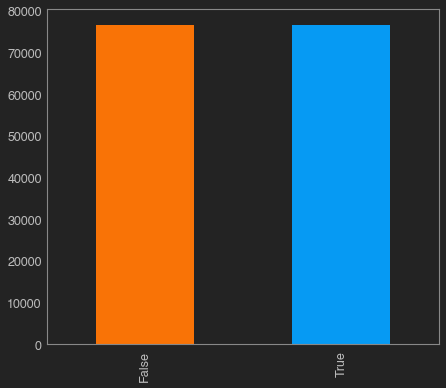

In [27]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
print(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

### Split into train / test data

In [28]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(145669, 15) (7667, 15)


## Explore the Curated DataFrame

In [29]:
# some useful boolean masks
is_funny = train['target'] == True

In [30]:
# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
922837,I saved 15% on car insurance by switching....,The gear to reverse and pulling away from the accident,482
792664,Who isn't allowed to watch PG movies?,Orphans.,8422
562540,My ex updated her status on Facebook to standing on the edge of a cliff.,So I poked her,510
930198,"TIL that Rick Astley will let you borrow any movie from his Pixar collection, except one.",He's never gonna give you Up,1327
863300,What is a huge benefit of dating an Ethiopian girl?,You know they'll swallow,361
402934,I wnet to an Indian restaurant and ordered biryani...,"The waiter said, sorry sir, I don’t know what a birlaurel is.",415
534717,Why was Pavlov's hair so soft?,Classical conditioning,955
17472,My boyfriend asked me if I wanted a threesome which of his friends I'd choose.,I shouldn't have named two.,4204
174588,"As a security guard, my Boss said my job is to watch the office","I’m on season 6 so far, and not sure what this has to do with security.",15870
712806,What fish is made of only two sodium ions?,2 Na :D,619


In [32]:
# examples of not funny jokes
train[train['score'] == 0][['title', 'selftext']].sample(10)

,title,selftext
927026,I didn't like the way my beard looked at first,but it grew on me.
635885,"""The Diarrhea of Anne Frank""",A good bathroom read
694602,Person 1 to person 2: whats up my brother from another mother,Person 2: aren't we siblings? Person 1: yeah sorry you're adopted
949151,"If your name is Sullivan, you've got a good name, but if you go by your nickname",you've Sully'd your good name
435162,Why do men like women in leather trousers?,Because they smell like a new car.
762949,Trump just won the US Presidential Election,"""It's Rigged!"""
902534,I think Marco Rubio has spine issues.,"Every time someone says Marco, someone says POLIO"
186098,Understanding a meme is like dissecting a frog.,"You'll understand it better, but it'll die in the process."
937282,Iphones walked out :p,Two Iphones walked out of a bar
532913,What do fishes use as a drug?,SEA-WEED


Saving figure density plot of log title length


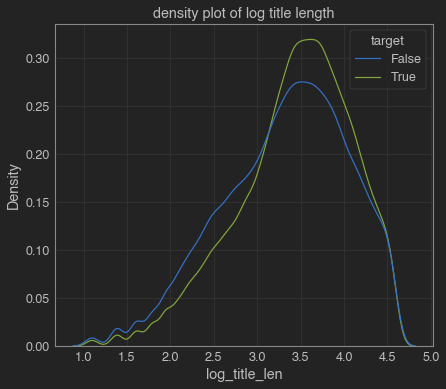

Saving figure density plot of log selftext length


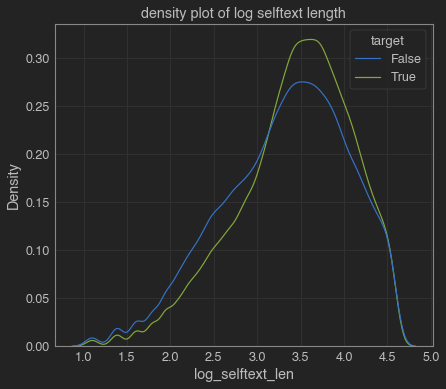

In [33]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()


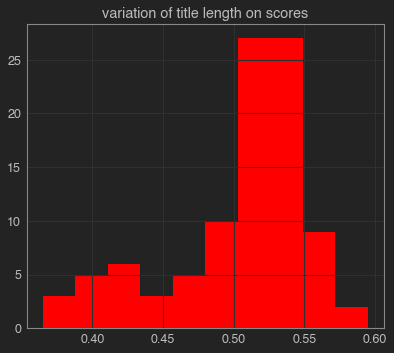

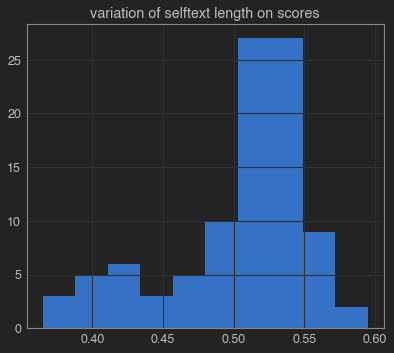

In [34]:
train.groupby(['title_len']).mean()['target'].hist(color='red')
plt.title('variation of title length on scores')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores')
plt.show()

### Examine Time Series Data

In [35]:
# making unix created_times into readable timestamps
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].set_index('created_at', drop=True).sort_index()
df_not_funny = train[~is_funny].set_index('created_at', drop=True).sort_index()

Saving figure submissions over time


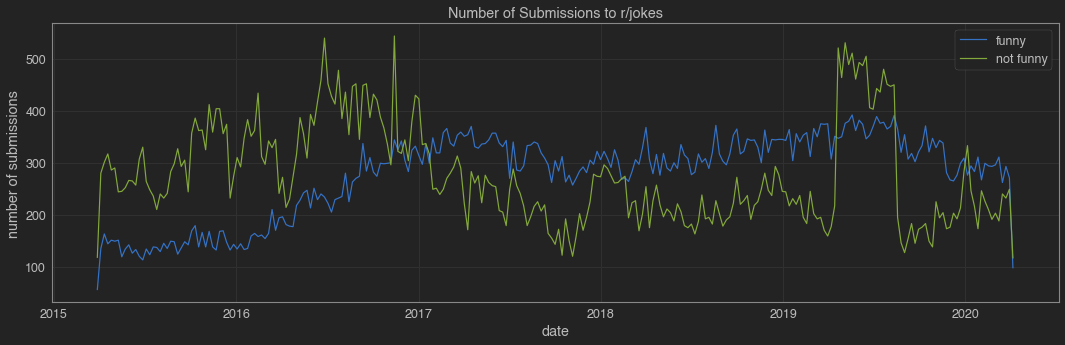

In [36]:
# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

Saving figure average submission per hour


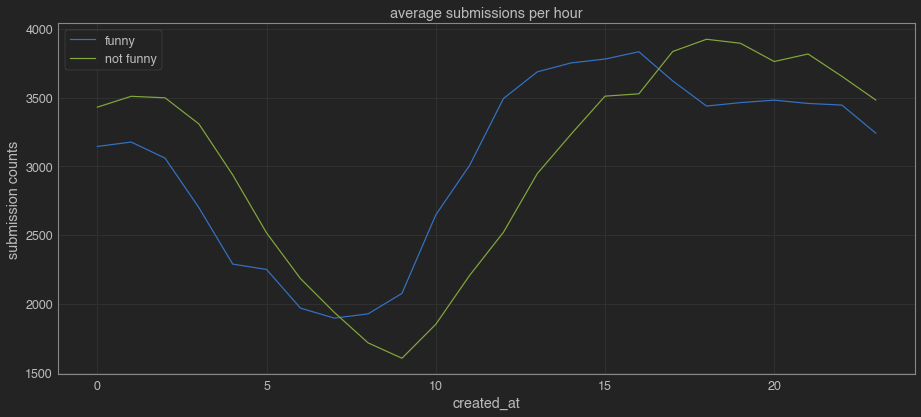

In [37]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

<AxesSubplot:xlabel='created_at', ylabel='type'>

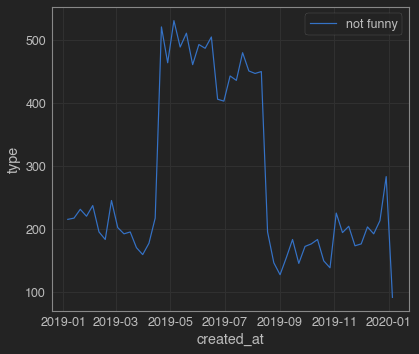

In [38]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')

In [39]:
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date.date()), str(end_date.date())
print(f'dates of anomaly: {start_date_not_funny_event} - {end_date_not_funny_event}')

dates of anomaly: 2019-04-07 - 2019-09-01


In [40]:
# save to pickle
pd.to_pickle(train, "./data/train.pkl")
pd.to_pickle(test, "./data/test.pkl")